In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import tensorflow as tf
import tfgraphviz as tfg

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ReluNet():
    def __init__(self, hidden_num = 1, batch_size = 100, training_epochs = 1000, learning_rate= 0.01):
        # Parameter initiation
        self.hidden_num = hidden_num
        self.batch_size = batch_size
        self.training_epochs = training_epochs
        self.learning_rate= learning_rate
        # clear previous graph
        tf.reset_default_graph()
        # Network Defination
        self.X = tf.placeholder("float")
        self.Y = tf.placeholder("float")
        
        self.hidden_num = hidden_num
        self.create_relu_net()

    def create_relu_net(self):
        # hidden layer        
        self.W = []; self.b = []; 
        self.h = []; self.h.append(self.X)       
        subnet_arch = list(np.hstack([np.array(1), np.array(self.hidden_num)]))
        
        with tf.variable_scope("Hierachical_ReluNet", reuse=tf.AUTO_REUSE):
            self.W.append(tf.get_variable("L1_W", initializer= \
                                          np.ones((subnet_arch[0], subnet_arch[1]), dtype = np.float32), trainable = False))
            self.b.append(tf.get_variable("L1_b", initializer= \
                                          -np.linspace(0, 1, self.hidden_num[0], dtype = np.float32)))
            self.h.append(tf.nn.relu(tf.matmul(self.h[0], self.W[0]) + self.b[0]))
            for i in range(len(subnet_arch)-2):
                self.W.append(tf.get_variable("L"+str(i+2)+"_W", initializer= \
                                 tf.random_normal([subnet_arch[i+1], subnet_arch[i+2]], mean=0.0, stddev=0.1)))
                self.b.append(tf.get_variable("L"+str(i+2)+"_b", initializer= \
                                 tf.random_normal([subnet_arch[i+2]], mean=0.0, stddev=0.001)))
                self.h.append(tf.matmul(self.h[-1], self.W[-1]) + self.b[-1])

            self.W.append(tf.get_variable("Output_W", initializer= \
                                     tf.random_normal([subnet_arch[-1], 1], mean=0.0, stddev=0.1)))
            self.b.append(tf.Variable(tf.random_normal([1], mean=0.0, stddev=0.001), name = "Output_b"))
            self.h.append(tf.matmul(self.h[-1], self.W[-1]) + self.b[-1])

        self.output = self.h[-1]
        self.cost = tf.reduce_mean(tf.square(self.Y - self.output)) 

        # optimization
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.cost)
        # initilize
        self.sess = tf.Session()
        self.init_op = tf.group(
                tf.local_variables_initializer(),
                tf.global_variables_initializer()
                )
        self.sess.run(self.init_op)

    def train(self, train_x, train_y):
        self.err_train = []
        train_size = train_x.shape[0]
        training_data = np.hstack([train_x,train_y])
        for epoch in xrange(self.training_epochs):
            mini_batches = [training_data[k:k+self.batch_size] for k in xrange(0, train_size, self.batch_size)]
            for i in range(len(mini_batches)):
                self.sess.run(self.train_op, feed_dict={self.X: mini_batches[i][:,:1], self.Y: mini_batches[i][:,1:]})
            if (epoch + 1) % 100 == 0:
                err_train = self.sess.run([self.cost], feed_dict={self.X: train_x, self.Y: train_y})
                self.err_train.append(err_train)
                print("Epoch ", epoch + 1, " Loss:", err_train)
        pred_train, err_train = self.sess.run([self.output, self.cost], feed_dict={self.X: train_x, self.Y: train_y})
        plt.figure(1, figsize=(8, 5))
        plt.plot(self.err_train)
        return pred_train 
        
    def predict(self, test_x):
        for i in range(self.hidden_layer):
            print("The " + str(i+1) +" Layer:",np.round(self.sess.run(self.hs[i], feed_dict={self.X: test_x}),3))
        pred = self.sess.run([self.output], feed_dict={self.X: test_x})
        print("The Final Output:",pred)
        return pred

# Test Example: Simple S-Curve

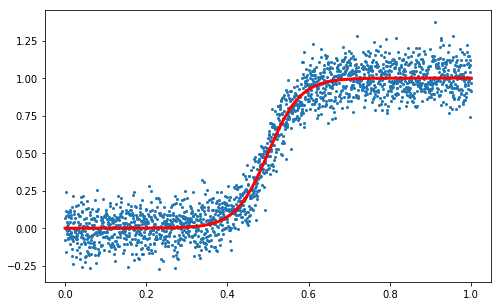

In [3]:
def S_Curve(DataNum, noise_level):
    x = np.linspace(0, 1, DataNum)
    y0 = 1/(1 + np.exp(-25*(x-0.5)))
    y = y0 + noise_level*np.random.normal(0, 1, DataNum) 
    return x, y0, y 

DataNum = 2000
x, y0, y = S_Curve(DataNum, 0.1)
train_x = x.reshape([-1,1])
train_y = MinMaxScaler().fit_transform(y.reshape([-1,1]))
plt.figure(1, figsize=(8, 5))
plt.plot(x, y, 'o', MarkerSize=2)
plt.plot(x, y0, color="red", LineWidth=3)
plt.show()

Epoch  100  Loss: [0.007990468]
Epoch  200  Loss: [0.004412664]
Epoch  300  Loss: [0.00391657]
Epoch  400  Loss: [0.003800182]
Epoch  500  Loss: [0.0037693135]
Epoch  600  Loss: [0.003761756]
Epoch  700  Loss: [0.00375122]
Epoch  800  Loss: [0.003743608]
Epoch  900  Loss: [0.003739964]
Epoch  1000  Loss: [0.0037382573]


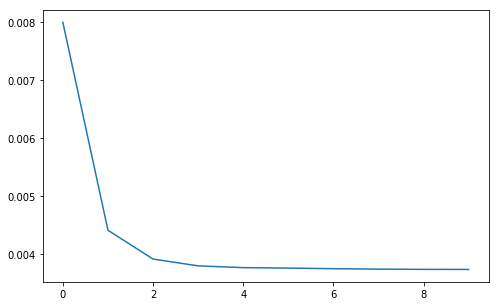

In [4]:
nnpar = [20, 2]
model = ReluNet(hidden_num = nnpar, batch_size = 100, training_epochs = 1000, learning_rate= 0.001)
pred_train = model.train(train_x, train_y)

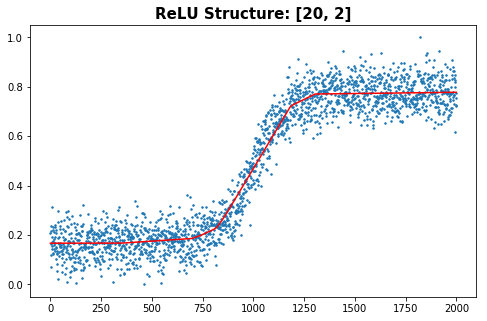

In [5]:
plt.figure(1, figsize=(8, 5))
plt.plot(train_y, '.', MarkerSize=3)
plt.plot(pred_train, color='red')
plt.title('ReLU Structure: ' + str(nnpar), fontsize=15, fontweight="bold")
plt.show()

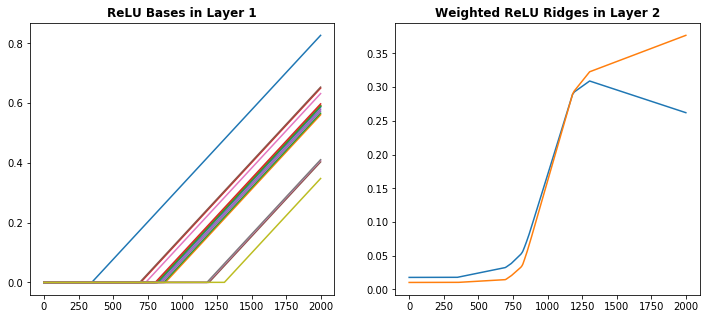

In [6]:
W1 = model.sess.run(model.W[0]); b1 = model.sess.run(model.b[0])
W2 = model.sess.run(model.W[1]); b2 = model.sess.run(model.b[1])
W3 = model.sess.run(model.W[2]); b3 = model.sess.run(model.b[2])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for j in range(W1.shape[1]):
    if (-b1[j] > 0) & (-b1[j] < 1):
        axs[0].plot(model.sess.run(model.h[1][:,j], feed_dict={model.X: train_x})) 
axs[0].set_title('ReLU Bases in Layer 1', fontweight="bold")
for k in range(W2.shape[1]):
    axs[1].plot(W3[k]*model.sess.run(model.h[2][:,k], feed_dict={model.X: train_x}))
axs[1].set_title('Weighted ReLU Ridges in Layer 2', fontweight="bold")
plt.show()

# Test Example: Doppler Curve

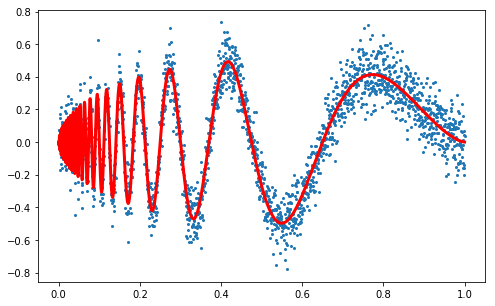

In [7]:
def doppler(DataNum, noise_level):
    x = np.linspace(0, 1, DataNum)
    y0 = np.sqrt(x*(1-x))*np.sin((2.1*np.pi)/(x+0.05))
    y = y0 + noise_level*np.random.normal(0, 1, DataNum) 
    return x, y0, y 

DataNum = 2000
x, y0, y = doppler(DataNum, 0.1)
train_x = x.reshape([-1,1])
train_y = MinMaxScaler().fit_transform(y.reshape([-1,1]))

plt.figure(1, figsize=(8, 5))
plt.plot(x, y, 'o', MarkerSize=2)
plt.plot(x, y0, color="red", LineWidth=3)
plt.show()

Epoch  100  Loss: [0.043371767]
Epoch  200  Loss: [0.035535485]
Epoch  300  Loss: [0.030080788]
Epoch  400  Loss: [0.027251149]
Epoch  500  Loss: [0.026017692]
Epoch  600  Loss: [0.025178188]
Epoch  700  Loss: [0.024436606]
Epoch  800  Loss: [0.023744708]
Epoch  900  Loss: [0.023066064]
Epoch  1000  Loss: [0.022395916]
Epoch  1100  Loss: [0.02174623]
Epoch  1200  Loss: [0.021140592]
Epoch  1300  Loss: [0.020552995]
Epoch  1400  Loss: [0.020063145]
Epoch  1500  Loss: [0.019460147]
Epoch  1600  Loss: [0.018940963]
Epoch  1700  Loss: [0.01843261]
Epoch  1800  Loss: [0.018003955]
Epoch  1900  Loss: [0.017644912]
Epoch  2000  Loss: [0.017340694]
Epoch  2100  Loss: [0.017073767]
Epoch  2200  Loss: [0.016825646]
Epoch  2300  Loss: [0.016589519]
Epoch  2400  Loss: [0.016374536]
Epoch  2500  Loss: [0.01619027]
Epoch  2600  Loss: [0.016027167]
Epoch  2700  Loss: [0.016643142]
Epoch  2800  Loss: [0.015705395]
Epoch  2900  Loss: [0.015580643]
Epoch  3000  Loss: [0.015469717]
Epoch  3100  Loss: [0.

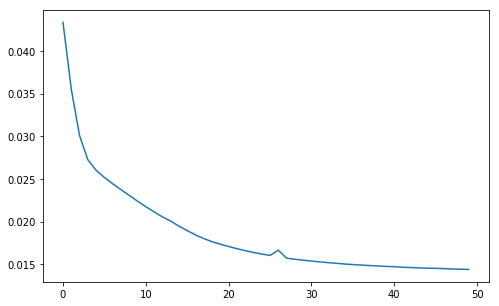

In [8]:
X = x.reshape([-1,1])
Y = y.reshape([-1,1])
nnpar = [40, 4]
model = ReluNet(hidden_num = nnpar, batch_size = 500, training_epochs = 5000, learning_rate= 0.001)
pred_train = model.train(train_x, train_y)

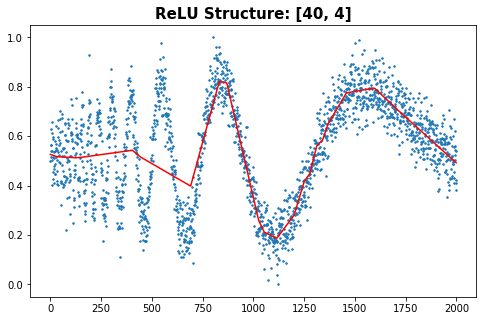

In [9]:
plt.figure(1, figsize=(8, 5))
plt.plot(train_y, '.', MarkerSize=3)
plt.plot(pred_train, color='red')
plt.title('ReLU Structure: ' + str(nnpar), fontsize=15, fontweight="bold")
plt.show()

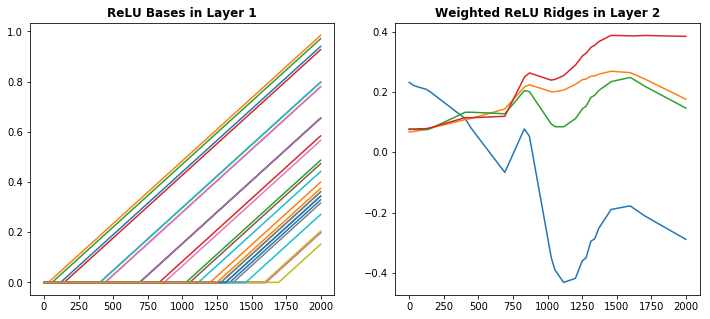

In [10]:
W1 = model.sess.run(model.W[0]); b1 = model.sess.run(model.b[0])
W2 = model.sess.run(model.W[1]); b2 = model.sess.run(model.b[1])
W3 = model.sess.run(model.W[2]); b3 = model.sess.run(model.b[2])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for j in range(W1.shape[1]):
    if (-b1[j] > 0) & (-b1[j] < 1):
        axs[0].plot(model.sess.run(model.h[1][:,j], feed_dict={model.X: X})) 
axs[0].set_title('ReLU Bases in Layer 1', fontweight="bold")
for k in range(W2.shape[1]):
    axs[1].plot(W3[k]*model.sess.run(model.h[2][:,k], feed_dict={model.X: X}))
axs[1].set_title('Weighted ReLU Ridges in Layer 2', fontweight="bold")
plt.show()